In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as sps

from arch import arch_model
import yfinance as yf
from matplotlib import collections as matcoll
import scipy.stats as sps
import math
import matplotlib.colors as mcolors

In [52]:
def Non_parametric_VaR(time,returns,days = 252,alpha = 0.05):
    #percent = -np.percentile(returns.values[time-days:time]/100, alpha*100, interpolation='lower')
    scene = np.sort(returns[time-days:time]/100)
    VaR = -scene[math.floor(days*(alpha))]
    ES = -np.mean(scene[0:math.floor(days*(alpha))])
    return [VaR*100,ES*100]

In [60]:
#Either send Probability weights as an argument to the function or create inside the function
#Better to send so that u can create different functions which generate different prob weights

#This returns geometric decay weights
def prob_weights1(n = 252,l = 0.995):
    return np.array([((1 - l)*l**(n-i))/(1 - l**n) for i in range(1, n+1)])
    
def Non_parametric_VaR_prob(time,returns,days=252,alpha=0.05):
    PW = prob_weights1(days)
    scene = returns[time-days:time]
    data = pd.DataFrame({'Weights': PW, 'Accumulated Weights': PW, 'Scenarios': scene/100})
    data = data.sort_values('Scenarios', ascending=True)
    data['Accumulated Weights'] = np.cumsum(data['Weights'])
    
    idx = np.where(data['Accumulated Weights'] > alpha)[0][0]
    #print("alpha value is ",alpha)
    VaR = -data['Scenarios'].values[idx]
    ES =-((data['Scenarios'].values[:idx-1]* data['Weights'].values[:idx-1]).sum() + (alpha - data['Accumulated Weights'].values[idx-1]) * data['Weights'].values[idx])/alpha
    return [VaR*100,ES*100]

In [46]:

def Non_parametric_VaR_Vol(time,returns,avg_ret,N,days=252,alpha=0.05,lamda=0.9):
    ## Start offset will used to decide the starting day for the EWMA here say its 200 note it has to be smaller than Window size
    start_off = 201
    init_ret = returns[:,(time-days)-start_off].reshape(-1,1)
    #print(init_ret)
    Def_Cov = np.dot(init_ret,init_ret.T)
    #print(Def_Cov.shape)
    #var_store = []
    #var_store.append(np.sum(Def_Cov)/(N*N))
    for i in range((time-days)-start_off+1,time-days-1):
        temp_ret = returns[:,i].reshape(-1,1)
        Def_Cov  = lamda*Def_Cov+(1-lamda)*np.dot(temp_ret,temp_ret.T)
    #print(Def_Cov)
    var_ewma = np.zeros((days + 1, 1))
    var_ewma[0,0] = np.sum(Def_Cov)/(N*N)
    for i in range(0,days):
        temp_ret = returns[:,time-days+i].reshape(-1,1)
        Def_Cov = lamda * Def_Cov + (1 - lamda) * np.dot(temp_ret,temp_ret.T)
        var_ewma[i+1,0] = np.sum(Def_Cov)/(N*N)
    #print(var_ewma[-1])    
    vol_ewma = var_ewma**0.5
    scale = vol_ewma[-1]/vol_ewma
    adj_ret = scale[:-1]*avg_ret[time-days:time]
    scene = np.sort(adj_ret)
    VaR =  -np.percentile(adj_ret, math.floor(alpha*100), interpolation='lower')
    ES = -np.mean(scene[0:math.floor(days*(alpha))])
    return [VaR*100,ES*100]

In [47]:
## This function considers it like a single stock so its single variate analysis
def Param_VaR_Normal_Sing(time,returns,days=252,alpha = 0.05):
    #Assuming Mean returns as 0 
    mean_return = 0
    vol = np.std(returns.values[time-days:time]) # this is the standard deviation of daily returns
    VaR = -vol*sps.norm.ppf(alpha, loc=mean_return, scale=1)
    ES = vol*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
    return [VaR,ES]

In [48]:
#Note return_arr this time takes in a numpy array
def Param_VaR_Normal_Mult(time,return_arr,N=1,days=252,alpha=0.05):
    #Assuming Mult_var Mean is zero
    #N is no of stocks or dim 0 of return_arr
    #print(return_arr.shape)
    Cov_Mat = np.cov(return_arr[:,time-days:time])
    vol = np.sqrt(np.sum(Cov_Mat)/(N*N))
    VaR = -vol*sps.norm.ppf(alpha, loc=0, scale=1)
    ES = vol*(sps.norm.pdf(sps.norm.ppf(alpha, loc=0, scale=1)))/(alpha)
    return [VaR,ES]

In [49]:
def Param_EWMA(time,return_arr,N=1,days=252,alpha = 0.05,lamda = 0.95):
    init_ret = return_arr[:,time-days].reshape(-1,1)
    Def_Cov = np.dot(init_ret,init_ret.T)
    for i in range(time-days+1,time):
        temp_ret = return_arr[:,i].reshape(-1,1)
        Def_Cov  = lamda*Def_Cov+(1-lamda)*np.dot(temp_ret,temp_ret.T)
    vol = np.sqrt(np.sum(Def_Cov)/(N*N))
    mean_return = 0
    VaR = -vol*sps.norm.ppf(alpha, loc=mean_return, scale=1)
    ES = vol*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
    return [VaR,ES]

In [50]:
def Garch_VaR(time,returns,days=252,alpha = 0.05):
    garch = arch_model(returns[time-days:time]/100, vol='garch', p=1, o=0, q=1)
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1, reindex=False)
    variance = garch_forecast.variance.values[0][0]
    mean_return = 0 ## Assumption of the model which is valid
    volatility = np.sqrt(variance)
    VaR = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
    ES = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
    return [VaR*100,ES*100]

In [51]:
START = "2020-01-01"
END = "2023-01-01"
INTERVAL = "1d" # Options: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo and 3mo (m refers to minute, h refers to hour, d refers to day, wk refers to week and mo refers to month)

TICKERS = [
    "AMZN", # Amazon (CONSUMER DISCRETIONARY)
    "BMY", # Bristol-Myers
    "TWI", #Twitter
    "MSFT" #Microsoft
]

stock_data = yf.download(
    tickers = TICKERS,
    start = START,
    end = END,
    interval = INTERVAL
).dropna()['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [29]:
print(stock_data.shape)

(756, 4)


In [30]:
col_names = list(stock_data.columns)
N = len(col_names)
avg_price = np.zeros(stock_data[col_names[0]].shape)
for name in col_names:
    avg_price+= np.array(stock_data[name])
avg_price /= N

avg_price_Series = pd.Series(avg_price)
avg_price_returns = avg_price_Series.pct_change()*100


returns = []
for name in col_names:
    returns.append(np.array(stock_data[name].pct_change()*100))
### Returns of all stocks fed as numpy-ndarray 
return_arr = np.array(returns)

In [31]:
stock_data.iloc[-1]

AMZN     84.000000
BMY      70.802475
MSFT    239.220825
TWI      15.320000
Name: 2022-12-30 00:00:00, dtype: float64

In [32]:
stock_data.head()

,AMZN,BMY,MSFT,TWI
Date,,,,
2020-01-02,94.900497,57.244278,155.761810,3.689306
2020-01-03,93.748497,56.738167,153.822311,3.699277
2020-01-06,95.143997,56.918915,154.219894,3.948555
2020-01-07,95.343002,57.777493,152.813751,3.898700
2020-01-08,94.598503,57.714230,155.247833,3.938584


##  Backtesting

In [54]:
Port_In = 1e6
N = 4
test_period = 252
est_day = 252
alpha1 = 0.05
alpha2 = 0.01
# 756 is the no of rows in the dataframe
Base_offset = 756-test_period+1

In [55]:
VaR1 = np.zeros(test_period)
ES1 = np.zeros(test_period)
exceedance1 = np.zeros(test_period)
loss = np.zeros(test_period)

VaR2 = np.zeros(test_period)
ES2 = np.zeros(test_period)
exceedance2 = np.zeros(test_period)
           

In [65]:
def plotter(graph_nm):
    plt.figure(figsize=(12,6), dpi=200)
    plt.plot(stock_data.index[-(test_period+1):-1], ES1, c = mcolors.TABLEAU_COLORS['tab:blue'], label = "Value-at-Risk-95% (1 day ahead)")
    plt.plot(stock_data.index[-(test_period+1):-1], ES2, c = mcolors.TABLEAU_COLORS['tab:olive'], label = "Value-at-Risk-99% (1 day ahead)")
    plt.plot(stock_data.index[-(test_period+1):-1], loss, c = mcolors.TABLEAU_COLORS['tab:red'], label = "Loss")
    plt.scatter(stock_data.index[-(test_period+1):-1][exceedance1 == 1], VaR1[exceedance1 == 1], s = 100*1.5, marker="x", color="black", label="Exceedances")
    plt.scatter(stock_data.index[-(test_period+1):-1][exceedance2 == 1], VaR2[exceedance2 == 1], s = 100*1.5, marker="x", color="black")
    plt.xlabel("Dates", fontsize = 12)
    plt.ylabel("Losses [%]", fontsize = 12)
    plt.title(graph_nm, fontsize = 14, y=1.03)
    plt.legend()
    plt.show()

## Backtesting NonParametric Var

In [66]:
for i in range(test_period):
    time = Base_offset+i
    
    Var_temp1,Es_temp1 = Non_parametric_VaR(time,avg_price_returns,test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Non_parametric_VaR(time,avg_price_returns,test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

Var_95_prediction for the last day is  3.493708887928959 %
ES_95_prediction for the last day is  45794.900430304864 $
Var_99_prediction for the last day is  4.965401047948214 %
ES_99_prediction for the last day is  59979.06567424277 $
No of exceedance for Var_95 is 20
No of exceedance for Var_99 is 11


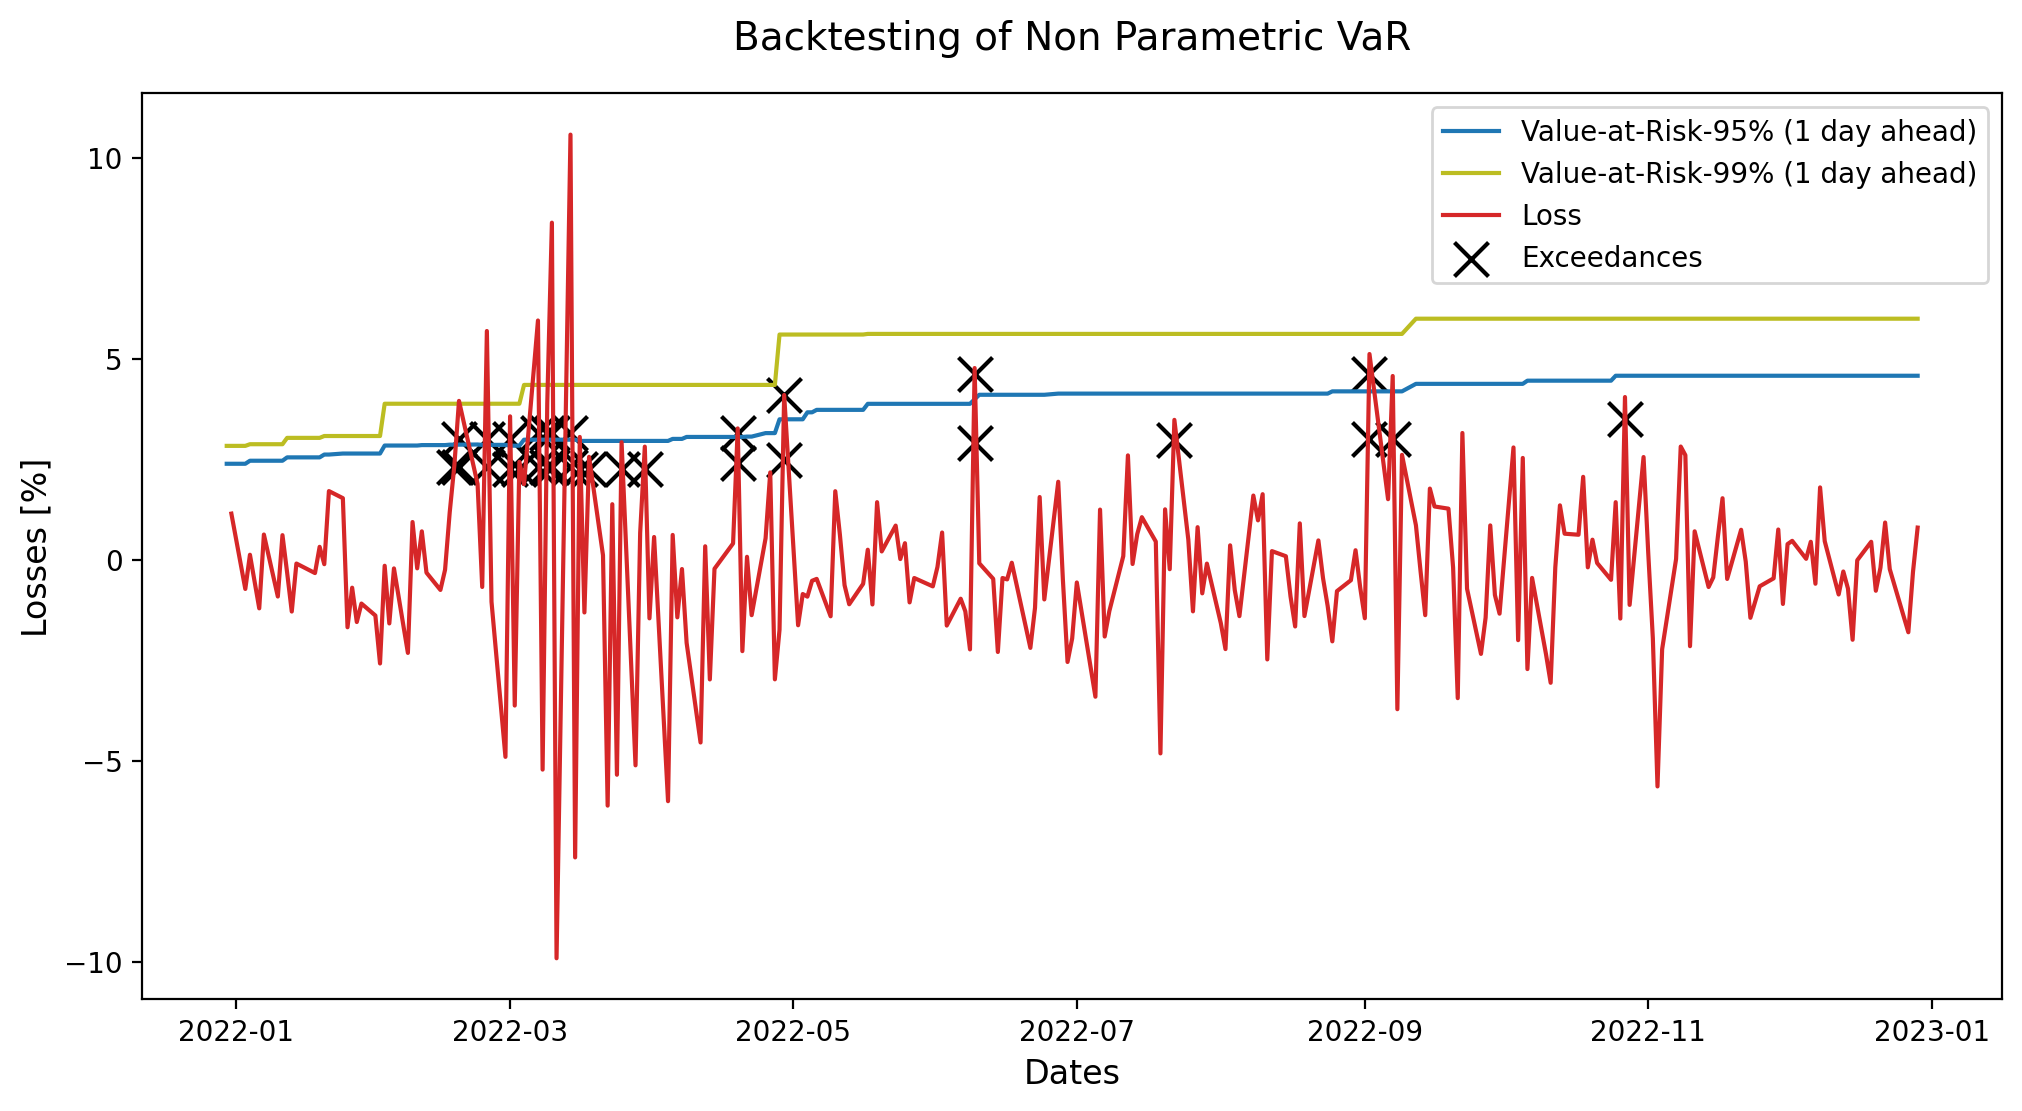

In [67]:
plotter("Backtesting of Non Parametric VaR")

## Backtesting Non Parametric Var Prob

In [68]:
for i in range(test_period):
    time = Base_offset+i
    
    Var_temp1,Es_temp1 = Non_parametric_VaR_prob(time,avg_price_returns,test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Non_parametric_VaR_prob(time,avg_price_returns,test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value i

alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value is  0.05
alpha value is  0.01
alpha value i

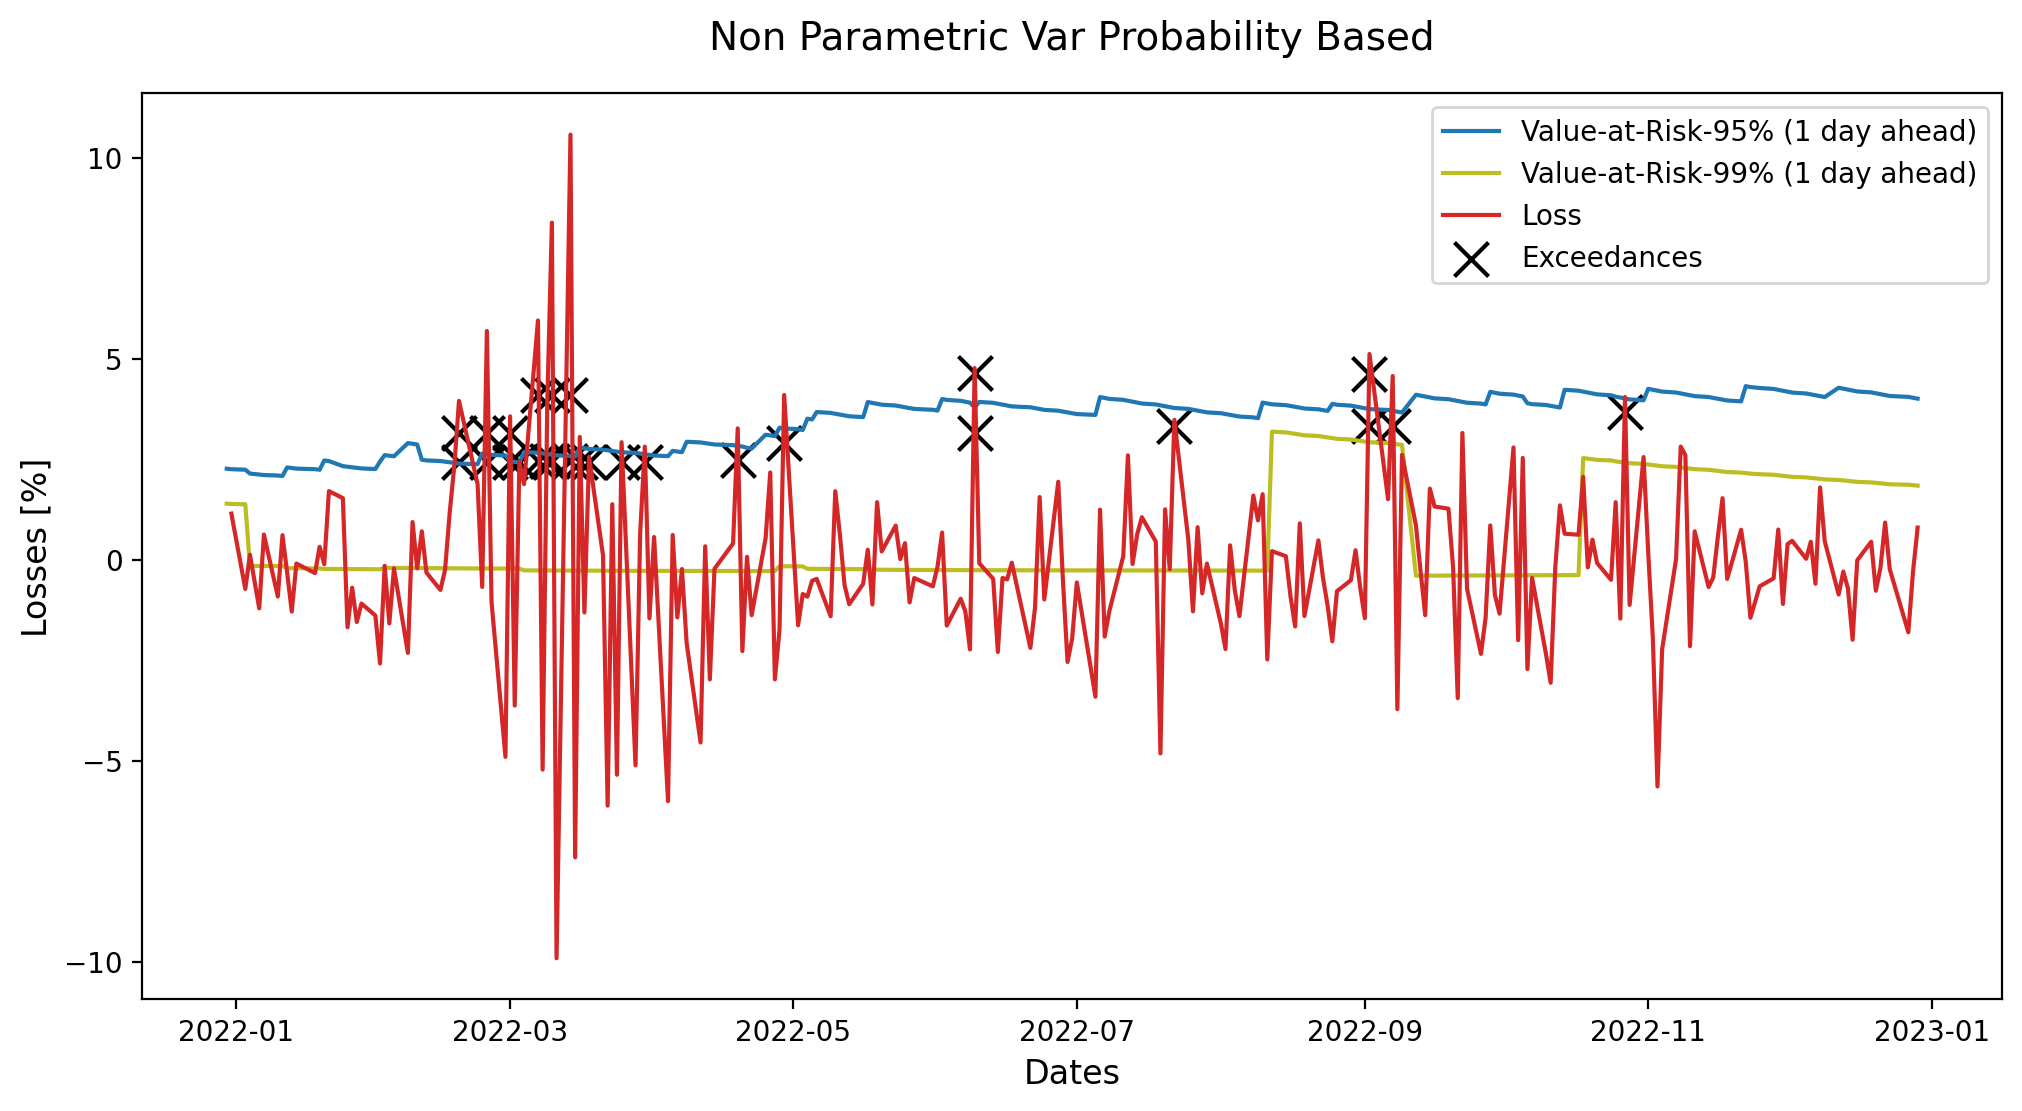

In [69]:
plotter("Non Parametric Var Probability Based")

## Backtesting for Non Parametric Var Volatility Based

In [70]:
lamda_par = 0.94
#Non_parametric_VaR_Vol(2517,return_arr/100,np.array(avg_price_returns).reshape(-1,1)/100,1,504,0.05,0.94)
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Non_parametric_VaR_Vol(time,return_arr,np.array(avg_price_returns).reshape(-1,1)/100,N,test_period,alpha1,lamda_par)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Non_parametric_VaR_Vol(time,return_arr,np.array(avg_price_returns).reshape(-1,1)/100,N,test_period,alpha2,lamda_par)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

Var_95_prediction for the last day is  3.3884875139024793 %
ES_95_prediction for the last day is  6862.401268075024 $
Var_99_prediction for the last day is  5.253469155660929 %
ES_99_prediction for the last day is  2802.0170019103757 $
No of exceedance for Var_95 is 12
No of exceedance for Var_99 is 5


In [ ]:
plotter("Backtesting for Non Parametric Var Volatility Based")

## Backtesting for Param_VaR_Normal_Singular

In [ ]:
Param_VaR_Normal_Sing(2517,avg_price_returns,days=252,alpha = 0.05)
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Param_VaR_Normal_Sing(time,avg_price_returns,test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Param_VaR_Normal_Sing(time,avg_price_returns,test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

In [ ]:
plotter("Backtesting for Param_VaR_Normal_Singular")

## Backtesting Param_VaR_Normal_Mult

In [ ]:
Param_VaR_Normal_Mult(2517,return_arr,return_arr.shape[0])
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Param_VaR_Normal_Mult(time,return_arr,N,test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Param_VaR_Normal_Mult(time,return_arr,N,test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

In [ ]:
plotter("Backtesting Param_VaR_Normal_Mult")

## Backtesting for Parameterized EWMA

In [ ]:
lamda_par = 0.95
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Param_EWMA(time,return_arr,N,test_period,alpha1,lamda_par)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Param_EWMA(time,return_arr,N,test_period,alpha2,lamda_par)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

In [ ]:
plotter("Backtesting for Parameterized EWMA")

## Backtesting for GARCH Model

In [ ]:
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Garch_VaR(time,np.array(avg_price_returns),test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Garch_VaR(time,np.array(avg_price_returns),test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]


In [ ]:
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

In [ ]:
plotter("Backtesting for GARCH Model")

In [ ]:
portfolioAtDayN = 100000 # Suppose we invest 100.000$ on day n
days_estimate = 252
testing_period = 252
alpha1 = 0.05 # "We are (1-alpha)% sure that the loss will not exceed .."
alpha2 = 0.01 # "We are (1-alpha)% sure that the loss will not exceed .."

VaR_95_1 = np.zeros(testing_period)
ES_95_1 = np.zeros(testing_period)
VaR_99_1 = np.zeros(testing_period)
ES_99_1 = np.zeros(testing_period)
exceedance_95 = np.zeros(testing_period) 
exceedance_99 = np.zeros(testing_period) 
loss = np.zeros(testing_period)
for i in range(testing_period):

  mean_return = 0 # Assumption
  used_returns = AMZN_returns.values[-(testing_period-i+days_estimate):-(testing_period-i)]
  volatility = np.std(used_returns)
  VaR_95_percentage = -volatility*sps.norm.ppf(alpha1, loc=mean_return, scale=1)/100
  VaR_95 = portfolioAtDayN*VaR_95_percentage
  ES_95_percentage = -(volatility*(sps.norm.pdf(sps.norm.ppf(alpha1, loc=mean_return, scale=1)))/alpha1)/100
  ES_95 = portfolioAtDayN*ES_95_percentage
  VaR_99_percentage = -volatility*sps.norm.ppf(alpha2, loc=mean_return, scale=1)/100
  VaR_99 = portfolioAtDayN*VaR_99_percentage
  ES_99_percentage = -(volatility*(sps.norm.pdf(sps.norm.ppf(alpha2, loc=mean_return, scale=1)))/alpha2)/100
  ES_99 = portfolioAtDayN*ES_99_percentage
  VaR_95_1[i] = VaR_95
  ES_95_1[i] = ES_95
  VaR_99_1[i] = VaR_99
  ES_99_1[i] = ES_99
    
  loss[i] = -portfolioAtDayN*AMZN_returns.values[-(testing_period-i)]/100
  exceedance_95[i] = VaR_95 < loss[i]
  exceedance_99[i] = VaR_99 < loss[i]
  
# The final VaR estimate (that we cannot test before seing another realisation of data). Coincides with the number calculated in 4)   
mean_return = 0 # Assumption
used_returns = AMZN_returns.values[-(days_estimate):]
volatility = np.std(used_returns)
VaR_95_percentage = -volatility*sps.norm.ppf(alpha1, loc=mean_return, scale=1)/100
VaR_95 = portfolioAtDayN*VaR_95_percentage
ES_95_percentage = -(volatility*(sps.norm.pdf(sps.norm.ppf(alpha1, loc=mean_return, scale=1)))/alpha1)/100
ES_95 = portfolioAtDayN*ES_95_percentage
VaR_99_percentage = -volatility*sps.norm.ppf(alpha2, loc=mean_return, scale=1)/100
VaR_99 = portfolioAtDayN*VaR_99_percentage
ES_99_percentage = (volatility*(sps.norm.pdf(sps.norm.ppf(alpha2, loc=mean_return, scale=1)))/alpha2)/100
ES_99 = portfolioAtDayN*ES_99_percentage
